In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import scipy.stats as stats
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from hyperopt import hp, fmin, tpe, Trials

In [13]:
df = pd.read_csv('../../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


In [14]:
mix_df = pd.read_csv('../../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]

In [15]:
merged_df = df.merge(mix_df, how='inner', left_index=True, right_index=True)
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,,
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


In [16]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,,
2024-04-12 17:00:00,57.37,0.084674,0.017899,0.044440,0.077898,0.132564,0.0,0.036925,0.007586,0.277852,0.066440,0.253722
2024-04-12 16:00:00,0.22,0.071990,0.014774,0.039949,0.054478,0.106525,0.0,0.030741,0.000887,0.365533,0.072082,0.243041
2024-04-12 15:00:00,0.18,0.064289,0.014542,0.035330,0.048058,0.094356,0.0,0.027463,0.000512,0.418821,0.069718,0.226909
2024-04-12 14:00:00,0.01,0.059697,0.017247,0.033430,0.046278,0.088183,0.0,0.025579,0.000441,0.449089,0.069300,0.210756
2024-04-12 13:00:00,-0.07,0.059205,0.017442,0.031908,0.050033,0.087802,0.0,0.025841,0.000090,0.454611,0.072151,0.200917
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25 13:00:00,76.11,0.064416,0.045516,0.027739,0.081596,0.082591,0.0,0.037558,0.000398,0.523383,0.053943,0.082861
2023-09-25 12:00:00,76.07,0.063494,0.040194,0.027562,0.081780,0.082351,0.0,0.039428,0.001226,0.512353,0.062199,0.089413
2023-09-25 11:00:00,89.01,0.064047,0.038097,0.027618,0.082332,0.094069,0.0,0.040218,0.001626,0.484586,0.076788,0.090619


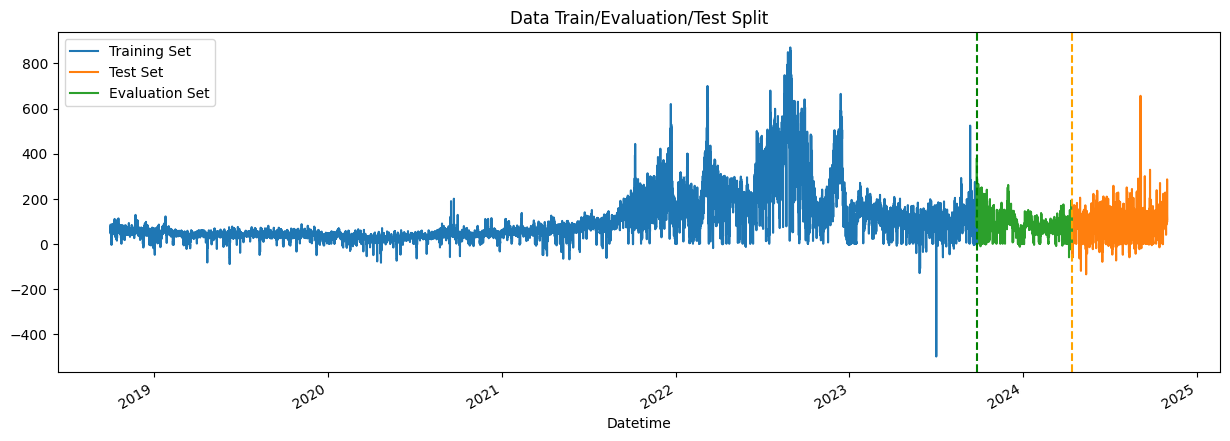

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
train["Price"].plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test["Price"].plot(ax=ax, label='Test Set')
eval["Price"].plot(ax=ax, label='Evaluation Set')
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [18]:
def create_features(df):
    print(df)
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

In [19]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
    "Biomass",
    "biomass_ma_3_hours",
    "biomass_ma_6_hours",
    "biomass_ma_1_days",
    "biomass_ma_3_days",
    "biomass_ma_7_days",
    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    "pumped_storage_generation_ma_1_days",
    "pumped_storage_generation_ma_3_days",
    "pumped_storage_generation_ma_7_days",
    "Hard Coal",
    "hard_coal_ma_3_hours",
    "hard_coal_ma_6_hours",
    "hard_coal_ma_1_days",
    "hard_coal_ma_3_days",
    "hard_coal_ma_7_days",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

                      Price   Biomass  Hard Coal     Hydro   Lignite  \
Datetime                                                               
2023-09-25 08:00:00  143.00  0.074518   0.070032  0.030380  0.135629   
2023-09-25 07:00:00  139.15  0.082151   0.073334  0.034915  0.151645   
2023-09-25 06:00:00  109.36  0.089667   0.070660  0.038529  0.138790   
2023-09-25 05:00:00   50.15  0.098486   0.068106  0.041557  0.106647   
2023-09-25 04:00:00    0.49  0.104751   0.064884  0.042631  0.107971   
...                     ...       ...        ...       ...       ...   
2018-10-01 04:00:00   47.59  0.092527   0.148990  0.019701  0.282126   
2018-10-01 03:00:00   47.38  0.093932   0.146157  0.020071  0.286085   
2018-10-01 02:00:00   51.41  0.094656   0.139489  0.020001  0.286402   
2018-10-01 01:00:00   56.10  0.094738   0.142985  0.020278  0.285558   
2018-10-01 00:00:00   59.53  0.095329   0.148649  0.020898  0.284357   

                     Natural Gas   Nuclear     Other  \
Datetim

In [20]:
model = xgb.XGBRegressor()

In [21]:
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.15, 0.2, 0.3],
#     "base_score": [0.5, 0.6, 0.7,0.8,0.9,1],
#     "n_estimators": [100, 200, 300, 500, 750, 1000],
#     "early_stopping_rounds": [10, 25, 50, 75, 100],
#     "max_depth": [3,5,7,10]
#  }

# search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)


param_dist = {
    "learning_rate": stats.uniform(0.01, 0.3),  # Continuous, no need for int
    "base_score": stats.uniform(0.5, 0.5),      # Continuous, range 0.5 to 1
    "n_estimators": stats.randint(100, 1001),   # Integer range, 100 to 1000
    "early_stopping_rounds": stats.randint(10, 101),  # Integer range, 10 to 100
    "max_depth": stats.randint(3, 11)           # Integer range, 3 to 10
}

# run randomized search
# n_iter_search = 15
# search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=n_iter_search, cv=5, n_jobs=-1)
# search.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)], 
#     verbose=True,
# )

# print("Best parameters found: ", search.best_params_)

In [22]:
space = {
    'base_score': hp.uniform('base_score', 0.1, 0.9),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 30, 50, 70, 100]),
    'max_depth': hp.choice('max_depth', [2,3,4, 5, 7, 9, 11, 13, 15, 20, 25]),
    'learning_rate': hp.loguniform('learning_rate', 0.001, 0.5),
    'n_estimators': hp.choice('n_estimators', [100, 300, 350, 400, 500, 1000, 10]),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', [0.1, 1, 5, 10, 20]),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
}

# Keeping track of the optimization history
trials = Trials()

def objective(params):

    model = xgb.XGBRegressor(
        base_score=params['base_score'],
        early_stopping_rounds=params['early_stopping_rounds'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

# Run the Hyperopt optimization
best = fmin(
    fn=objective,            # Objective function
    space=space,             # Hyperparameter space
    algo=tpe.suggest,        # Optimization algorithm
    max_evals=50,            # Number of trials
    trials=trials,           # Store trials history
)

# Display best parameters
print("Best hyperparameters:", best)

# Extract the best hyperparameters
best_params = {
    'base_score': best['base_score'],
    'early_stopping_rounds': best['early_stopping_rounds'],
    'max_depth': best['max_depth'],
    'learning_rate': best['learning_rate'],
    'n_estimators': best['n_estimators'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'min_child_weight':best['min_child_weight'],
}

# Train the final model with the best hyperparameters on the full dataset
final_model = xgb.XGBRegressor(
    base_score=best_params['base_score'],
    early_stopping_rounds=best_params['early_stopping_rounds'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective='reg:squarederror',
)

final_model.fit(X_train, y_train,  eval_set=[(X_test, y_test)])

# Predict on the test set or validation set
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print("Final model RMSE:", final_rmse)


100%|██████████| 50/50 [00:21<00:00,  2.33trial/s, best loss: 14.15659538773586] 
Best hyperparameters: {'base_score': np.float64(0.571285107809624), 'colsample_bytree': np.float64(0.8457299607917089), 'early_stopping_rounds': np.int64(1), 'gamma': np.float64(0.9419730365781261), 'learning_rate': np.float64(1.0464440767714098), 'max_depth': np.int64(8), 'min_child_weight': np.int64(4), 'n_estimators': np.int64(2), 'subsample': np.float64(0.4821599568819539)}
[0]	validation_0-rmse:18.49499
[1]	validation_0-rmse:15.12550
Final model RMSE: 15.12550092417928


autml gridsearch autoscikit-learn